# ***Assignment 1.3 - CAVI***
Consider the model defined by Equation (10.21)-(10-23) in Bishop, for which DGM is presented below:

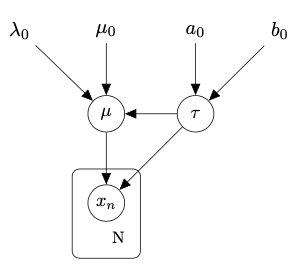

### ***Question 1.3.12:***

Implement a function that generates data points for the given model.

In [1]:
import numpy as np
def generate_data(mu, tau, N):
  # Insert your code here
  sigma = np.sqrt(1/tau)
  D = np.random.normal(mu, sigma, N)
  return D


Set μ = 1, τ = 0.5 and generate datasets with size N=10,100,1000. Plot the histogram for each of 3
datasets you generated.



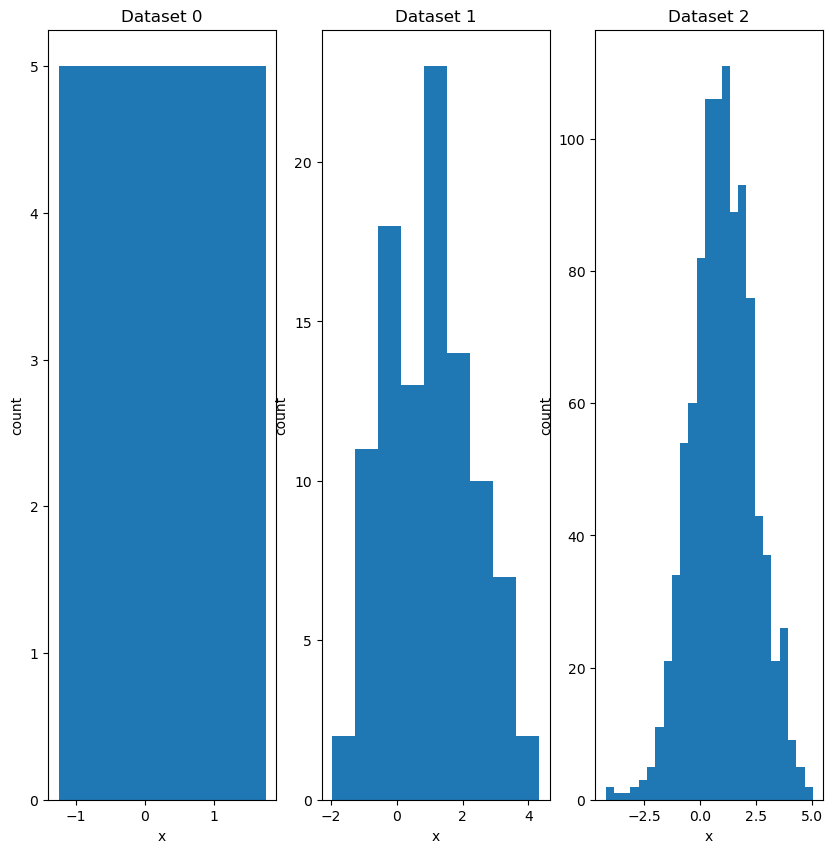

In [2]:
mu = 1
tau = 0.5


np.random.seed(910706)

dataset_1 = generate_data(mu, tau, 10)
dataset_2 = generate_data(mu, tau, 100)
dataset_3 = generate_data(mu, tau, 1000)

data = [dataset_1, dataset_2, dataset_3]

import matplotlib.pyplot as plt

# Visulaize the datasets via histograms
# Insert your code here

fig, axes = plt.subplots(ncols=3, nrows=1, figsize=(10,10))

for i, dataset in enumerate(data):
    axis = axes[i]
    axis.hist(dataset, label=f'Dataset {i}', bins='fd')
    axis.set_title(f'Dataset {i}')
    axis.set_xlabel('x')
    axis.set_ylabel('count')

fig.savefig('sampled_datasets')


### ***Question 1.3.13:***

Find ML estimates of the variables μ and τ

In [3]:
def ML_est(data):
  # insert your code
  eps = 0.00001
  mu_ml = np.mean(data)
  tau_ml = 1/(np.var(data) + eps)
  return mu_ml, tau_ml

### ***Question 1.3.14:***
You will implement the VI algorithm for the variational distribution in Equation (10.24) in Bishop. Start with introducing the prior parameters:

In [4]:
# prior parameters
mu_0 = 0.5
lambda_0 = 1
a_0 = 3
b_0 = 7

Continue with a helper function that computes ELBO:


$\mathcal{L} = \mathop{\mathbb{E_{\mu, \tau}}} \left[ \log p(X, Z) - \log q(Z) \right]$


\begin{gather}
\mathop{\mathbb{E_{\mu, \tau}}} \left[ \log p(x_n | \tau, \mu) \right] = \mathop{\mathbb{E_\tau}} [\log \tau] - \frac{\mathop{\mathbb{E}} [\tau]}{2}\mathop{\mathbb{E_\mu}}[(x_n - \mu)^2] - \frac{1}{2} \log{ 2\pi} \\
\mathop{\mathbb{E_{\mu, \tau}}} \left[ \log p(\mu | \tau) \right] = \mathop{\mathbb{E_\tau}} [\log \lambda_0 \tau] - \frac{\mathop{\mathbb{E}} [\tau]}{2}\mathop{\mathbb{E_\mu}}[(\mu - \mu_0)^2] - \frac{1}{2} \log{ 2\pi} \\

\mathop{\mathbb{E_{\mu, \tau}}} [p(\tau)] = a_0 \log b_0  - \log \Gamma(a_0) + (a_0 - 1) \mathop{\mathbb{E}} [\log \tau] - b_0 \mathop{\mathbb{E}} [\tau] \\

\mathop{\mathbb{E}} \left[ -\log q(\tau)\right] = H_\tau \\

\mathop{\mathbb{E}} \left[ -\log q(\mu)\right] = H_\mu \\


\end{gather}

In [5]:
from scipy.stats import gamma, norm
import scipy.special as sp_spec

def compute_elbo (D, a_0, b_0, mu_0, lambda_0, a_N , b_N, mu_N, lambda_N):
    
    eps = 0.0000001
    
    N = D.shape[0]  
    E_log_tau = sp_spec.digamma(a_N + eps) - np.log(b_N + eps)
    E_tau = a_N / b_N
    E_mu = mu_N
    E_mu_squared = 1/lambda_N + mu_N**2

  # given the prior and posterior parameters together with the data,
  # compute ELBO here

  #corresponding to equation (1)
    component_1 = N/2*(E_log_tau - np.log(2*np.pi))-(1/2)*E_tau*(np.sum(np.square(D))-2*E_mu*np.sum(D)+ N*E_mu_squared)
  #equation 2:
    component_2 =  1/2*(E_log_tau + np.log(lambda_0 + eps)- np.log(2*np.pi)) - (lambda_0/2)*E_tau*(mu_0**2-2*E_mu*mu_0+ E_mu_squared)

  #equation 3:
    component_3 = a_0*np.log(b_0 + eps)+ (a_0 - 1)*E_log_tau - b_0*E_tau - sp_spec.gammaln(a_0)

  #entropy 1, entropy of a gamma:
    entropy_1 = a_N - np.log(b_N + eps) + sp_spec.gammaln(a_N + eps) + (1 - a_N)*sp_spec.digamma(a_N + eps)
  
  #entropy 2, entropy of a normal:
    entropy_2 = 0.5*np.log(2*np.pi) - 0.5*np.log(lambda_N + eps) + 0.5
  
    # print(f"c1: {component_1},c2: {component_2}, c3: {component_3}, h1: {entropy_1}, h2: {entropy_2}")

    return component_1 + component_2 + component_3 + entropy_1 + entropy_2


Now, implement the CAVI algorithm:

In [6]:
def update_q_mu(D, mu_0, lambda_0, a_N , b_N):
    N = D.shape[0]  

    E_tau = a_N / b_N
    lambda_N = (lambda_0+N)*E_tau
    mu_N = (np.sum(D)+mu_0*lambda_0)/(lambda_0+N)
    
    return lambda_N, mu_N


def update_q_tau(D, a_0, b_0, mu_0, lambda_0, mu_N, lambda_N):
    N = D.shape[0] 
    E_mu = mu_N
    E_mu_squared = 1/lambda_N + mu_N**2
    
    a_N = a_0+N/2+0.5
    b_N = b_0 + 1/2*(np.sum(np.square(D))+(mu_0**2)*lambda_0-2*E_mu*(lambda_0*mu_0+np.sum(D))+((lambda_0+N)*E_mu_squared))

    return a_N, b_N


def CAVI_algorithm(D, n_iter, a_0, b_0, mu_0, lambda_0):
    N = D.shape[0] 
    a_N, b_N = a_0 , b_0
  # Store output per iteration
    elbo = np.zeros(n_iter)

    for i in range(0, n_iter):
    # CAVI updates
    # q(mu) update
        lambda_N, mu_N = update_q_mu(D, mu_0, lambda_0, a_N , b_N)

    # q(tau) update
        a_N, b_N = update_q_tau(D, a_0, b_0, mu_0, lambda_0, mu_N, lambda_N)

    # ELBO
        elbo[i] = compute_elbo(D, a_0, b_0, mu_0, lambda_0, a_N , b_N, mu_N, lambda_N)

    return a_N, b_N, lambda_N, mu_N, elbo


### ***Question 1.3.15:***

What is the exact posterior? First derive it in closed form, and then implement a function that computes it for the given parameters:


In [7]:
def compute_exact_posterior(D, a_0, b_0, mu_0, lambda_0):
  # your implementation
    N = D.shape[0]
    a_N = a_0 + N/2
    b_N = b_0 + 1/2*(np.sum(np.square(D))+mu_0**2*lambda_0-((np.sum(D)+mu_0*lambda_0)**2)/(N+lambda_0))
    lambda_N = N + lambda_0
    mu_N = (np.sum(D)+mu_0*lambda_0)/(N+lambda_0)
    
    return a_N, b_N, lambda_N, mu_N

### ***Question 1.3.16:***
Run the VI algorithm on the datasets. Compare the inferred variational
distribution with the exact posterior and the ML estimate. Visualize the results and discuss your
findings.



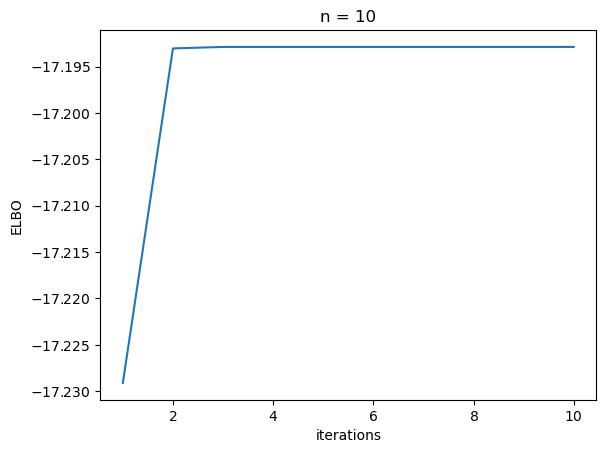

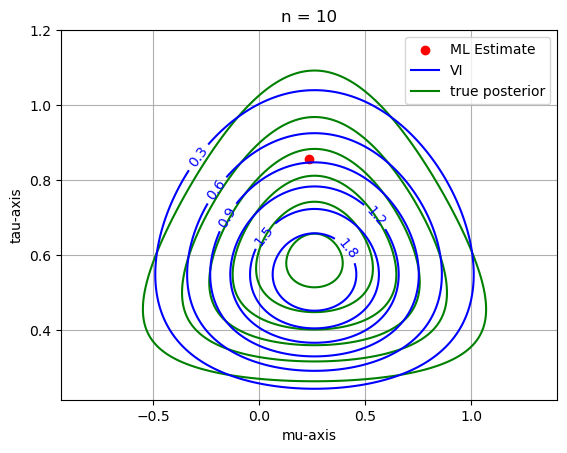

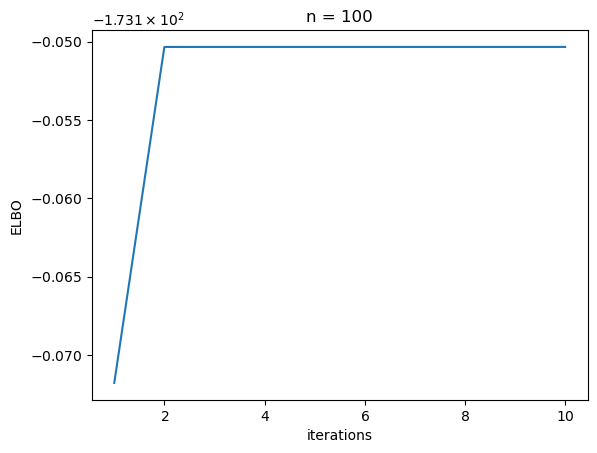

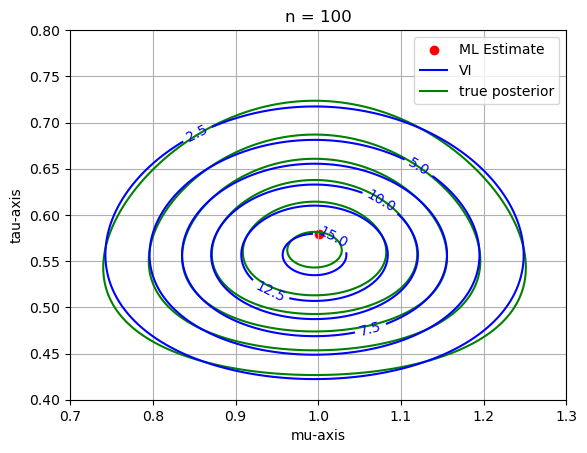

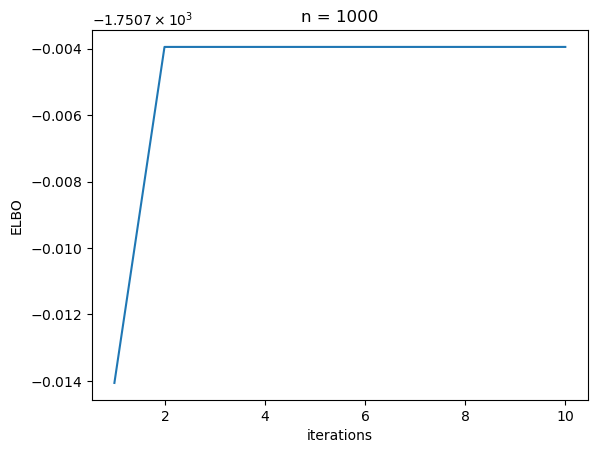

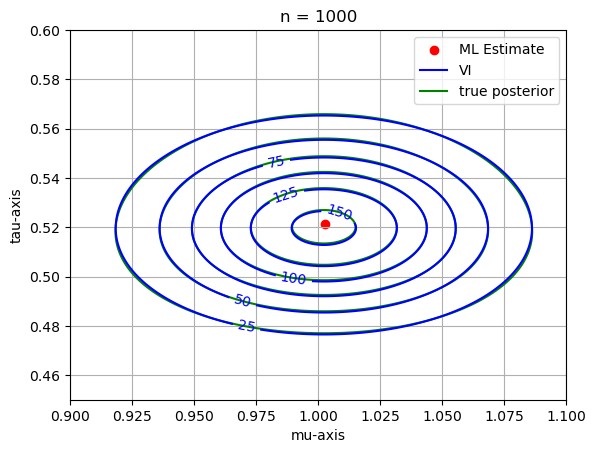

In [8]:
# Insert your main code here
import scipy.special as sp_spec

from matplotlib.lines import Line2D

# Example flow for dataset_2:
  ##  mu_ml, tau_ml = ML_est(dataset_2)
  ##  a_N, b_N, mu_N, lambda_N, elbos = CAVI(dataset_2, a_0, b_0, mu_0, lambda_0)
  ##  plot elbos, show convergence
  ##  exact_post_dist = compute_exact_posterior(dataset_2, a_0, b_0, mu_0, lambda_0)
  ##  compare exact_post_dist with the CAVI result ( = q(a_N, b_N, mu_N, lambda_N) ) using for ex. contour plots, show also ML estimate on this plot

# Generating data points for x and y
estimates = [ML_est(d) for d in data]

# for better obsevation 
x = np.linspace(estimates[0][0]- 1/estimates[0][1], estimates[0][0]+ 1/estimates[0][1], 1000)  # Creating 5000 points between -5 and 5
y = np.linspace(estimates[0][1]*0.25, 1.2, 1000)  # Creating 1000 points between -5 and 5
X1, Y1 = np.meshgrid(x, y)  # Creating a grid of x and y values

x2 = np.linspace(0.7, 1.3, 1000)  # Creating 1000 points between -5 and 5
y2 = np.linspace(0.4, 0.8, 1000)  # Creating 1000 points between -5 and 5
X2, Y2 = np.meshgrid(x2, y2)  # Creating a grid of x and y values

x3 = np.linspace(0.9, 1.1, 1000)  # Creating 1000 points between -5 and 5
y3 = np.linspace(0.45, 0.6, 1000)  # Creating 1000 points between -5 and 5
X3, Y3 = np.meshgrid(x3, y3)  # Creating a grid of x and y values

table = [(X1,Y1),(X2,Y2),(X3,Y3)]

    
def log_normal_distribution(x, mean, tau):
    eps = 0.0000001
    return 0.5 * np.log(tau/(2 * np.pi) + eps) - 0.5 * tau * (x - mean)**2

def log_gamma_distribution(x, alpha, beta):
    eps = 0.0000001
    return alpha * np.log(beta+ eps) - sp_spec.gammaln(alpha + eps) + (alpha - 1) * np.log(x + eps) - beta * x

def log_gammanormal_distribution(mu, tau, mu_0, lambda_0, a_0, b_0):
    log_normal = log_normal_distribution(mu, mu_0, lambda_0 * tau)
    log_gamma = log_gamma_distribution(tau, a_0, b_0)
    return log_normal + log_gamma

# prior
mu_0 = 0.5
lambda_0 = 1
a_0 = 3
b_0 = 7

# handles
vi_line = Line2D([0], [0], label='VI', color='blue')
post_line = Line2D([0], [0], label='true posterior', color='green')

n_iter = 10
for i, D in enumerate(data):
    X, Y = table[i]

    elbo_fig = plt.figure(2*i + 1)
    elbo_ax = elbo_fig.add_subplot(111)    
    a_N, b_N, lambda_N, mu_N, elbo = CAVI_algorithm(D, n_iter, a_0, b_0, mu_0, lambda_0)
    elbo_ax.plot(list(range(1, n_iter+1)), elbo, label=f'CAVI')
    
    elbo_ax.ticklabel_format(useMathText=True)
    elbo_ax.set_title(f"n = {len(D)}")
    
    fig = plt.figure(2*i)
    ax = fig.add_subplot(111)
    
    a_exact, b_exact, lambda_exact, mu_exact = compute_exact_posterior(D, a_0, b_0, mu_0, lambda_0)
    
    approximation = np.exp(log_normal_distribution(X, mu_N,lambda_N)+log_gamma_distribution(Y, a_N, b_N))
    true_posterieur = np.exp(log_gammanormal_distribution(X, Y, mu_exact, lambda_exact, a_exact, b_exact))
    contour = ax.contour(X, Y, true_posterieur, colors='green',levels=6)


    mu_ml, tau_ml = ML_est(D)
    contour = ax.contour(X, Y, approximation, colors="blue",levels=6) 
    ax.clabel(contour, contour.levels, inline=True, fontsize=10)
    mle_x = mu_N
    point='MLE'+'('+str(round(mu_ml,3))+';'+str(round(tau_ml,3))+')'
    
    ax.scatter(mu_ml, tau_ml, color='red', label = 'ML Estimate')
    # ax.annotate(point, (mu_ml, tau_ml), textcoords="offset points", xytext=(10,10), ha='center', fontsize=8)

    elbo_ax.set_ylabel("ELBO")

    ax.set_ylabel('tau-axis')
    ax.set_xlabel('mu-axis')
    elbo_ax.set_xlabel("iterations")
    ax.set_title(f'n = {len(D)}')
    ax.grid(True)

    handles, labels = ax.get_legend_handles_labels()
    handles.extend([vi_line, post_line])    
    ax.legend(handles=handles) 

    fig.savefig(f"VI-{i}")
    
    elbo_fig.savefig(f'elbo-{i}')
    
